Data Cleaning

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import glob
from scipy import stats

In [6]:
def load_data(file_path):
    """
    Load CSV market data file
    """
    # First check if the csv has a column named 'Date' or 'datetime'
    try:
        # Read just the header to check column names
        header = pd.read_csv(file_path, nrows=0)
        date_col = None
        
        if 'Date' in header.columns:
            date_col = 'Date'
        elif 'datetime' in header.columns:
            date_col = 'datetime'
        
        if date_col:
            df = pd.read_csv(file_path, parse_dates=[date_col])
        else:
            # No date column found, load without parsing dates
            df = pd.read_csv(file_path)
            print("Warning: No date column found. Data loaded without date parsing.")
            
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def check_data_info(df):
    """
    Quick check of data shape, columns and datatypes
    """
    print(f"Data shape: {df.shape}")
    print("\nColumn information:")
    print(df.info())
    print("\nMissing values per column:")
    print(df.isnull().sum())
    print("\nFirst 5 rows:")
    print(df.head())
    return df

def handle_missing_values(df):
    """
    Handle missing values in the dataset
    """
    # Check for missing values before handling
    missing_before = df.isnull().sum()
    
    # Forward fill price data (use previous day's value)
    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    price_cols = [col for col in price_cols if col in df.columns]
    if price_cols:
        df[price_cols] = df[price_cols].fillna(method='ffill')
        # For any remaining missing values at the beginning, use backfill
        df[price_cols] = df[price_cols].fillna(method='bfill')
    
    # For volume, replace missing with median or 0
    if 'Volume' in df.columns:
        df['Volume'] = df['Volume'].fillna(df['Volume'].median())
    
    # Handle any remaining missing values
    df = df.fillna(df.median(numeric_only=True))
    
    # Check for missing values after handling
    missing_after = df.isnull().sum()
    
    print("Missing values before handling:")
    print(missing_before)
    print("\nMissing values after handling:")
    print(missing_after)
    
    return df

def remove_duplicates(df):
    """
    Remove duplicate rows from the dataset
    """
    duplicate_count = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_count}")
    
    if duplicate_count > 0:
        df = df.drop_duplicates(keep='first')
        print(f"Dropped {duplicate_count} duplicate rows")
    
    return df

def add_date_features(df):
    """
    Extract useful date features from the Date or datetime column
    """
    # Identify which date column is available
    date_col = None
    if 'Date' in df.columns:
        date_col = 'Date'
    elif 'datetime' in df.columns:
        date_col = 'datetime'
    
    if date_col:
        df['Year'] = df[date_col].dt.year
        df['Month'] = df[date_col].dt.month
        df['Day'] = df[date_col].dt.day
        df['DayOfWeek'] = df[date_col].dt.dayofweek
        df['Quarter'] = df[date_col].dt.quarter
        df['IsMonthEnd'] = df[date_col].dt.is_month_end.astype(int)
        
        # Set date column as index but keep the date features we just created
        df = df.set_index(date_col)
    else:
        print("Warning: No date column found for extracting date features.")
    
    return df

def calculate_technical_indicators(df):
    """
    Calculate common technical indicators
    """
    # Check if we have necessary price columns
    if 'close' not in df.columns:
        print("Close prices not available, skipping technical indicators")
        return df
    
    # Moving Averages
    df['MA_5'] = df['close'].rolling(window=5).mean()
    df['MA_20'] = df['close'].rolling(window=20).mean()
    df['MA_50'] = df['close'].rolling(window=50).mean()
    
    # Exponential Moving Averages
    df['EMA_5'] = df['close'].ewm(span=5, adjust=False).mean()
    df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
    df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    
    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df['Bollinger_Middle'] = df['close'].rolling(window=20).mean()
    df['Bollinger_Std'] = df['close'].rolling(window=20).std()
    df['Bollinger_Upper'] = df['Bollinger_Middle'] + (df['Bollinger_Std'] * 2)
    df['Bollinger_Lower'] = df['Bollinger_Middle'] - (df['Bollinger_Std'] * 2)
    
    # Calculate returns
    df['Daily_Return'] = df['close'].pct_change()
    df['Log_Return'] = np.log(df['close'] / df['close'].shift(1))
    
    # Volatility (20-day rolling std of returns)
    df['Volatility_20d'] = df['Daily_Return'].rolling(window=20).std()
    
    return df

def identify_outliers(df, columns=None, z_threshold=3):
    """
    Identify outliers in specified columns using z-score
    """
    if columns is None:
        # Use all numeric columns except date columns
        columns = df.select_dtypes(include=np.number).columns.tolist()
    
    outliers_summary = {}
    
    for column in columns:
        if column in df.columns:
            # Calculate z-scores
            z_scores = np.abs(stats.zscore(df[column].dropna()))
            outliers = np.where(z_scores > z_threshold)[0]
            
            outliers_summary[column] = len(outliers)
            
            print(f"Column {column}: {len(outliers)} outliers detected ({len(outliers)/len(df[column].dropna())*100:.2f}%)")
    
    return outliers_summary

def handle_outliers(df, method='winsorize', columns=None, z_threshold=3):
    """
    Handle outliers in the dataset
    Methods: 'winsorize', 'cap', 'remove'
    """
    if columns is None:
        # Use all numeric columns except date columns
        columns = df.select_dtypes(include=np.number).columns.tolist()
    
    for column in columns:
        if column in df.columns:
            # Calculate z-scores
            z_scores = np.abs(stats.zscore(df[column].dropna()))
            outlier_indices = np.where(z_scores > z_threshold)[0]
            
            if len(outlier_indices) == 0:
                continue
                
            if method == 'winsorize':
                # Winsorize: cap values at specific percentiles
                lower_bound = np.percentile(df[column].dropna(), 1)
                upper_bound = np.percentile(df[column].dropna(), 99)
                df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
                
            elif method == 'cap':
                # Simple capping based on z-score
                df_no_na = df[column].dropna()
                mean_val = df_no_na.mean()
                std_val = df_no_na.std()
                
                lower_bound = mean_val - (z_threshold * std_val)
                upper_bound = mean_val + (z_threshold * std_val)
                
                df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
                
            elif method == 'remove':
                # Replace outliers with NaN, then handle missing values
                mask = (np.abs(stats.zscore(df[column].dropna())) > z_threshold)
                outlier_indices = df[column].dropna().index[mask]
                df.loc[outlier_indices, column] = np.nan
                
                # Fill NaN with appropriate method (e.g., interpolation)
                df[column] = df[column].interpolate(method='linear')
    
    return df

def normalize_features(df, method='minmax', columns=None):
    """
    Normalize or standardize features
    Methods: 'minmax', 'standard', 'robust'
    """
    if columns is None:
        # Use all numeric columns
        columns = df.select_dtypes(include=np.number).columns.tolist()
    
    normalized_df = df.copy()
    
    for column in columns:
        if column in normalized_df.columns:
            if method == 'minmax':
                # Min-Max normalization (0 to 1)
                min_val = normalized_df[column].min()
                max_val = normalized_df[column].max()
                normalized_df[column] = (normalized_df[column] - min_val) / (max_val - min_val)
                
            elif method == 'standard':
                # Standardization (z-score normalization)
                mean_val = normalized_df[column].mean()
                std_val = normalized_df[column].std()
                normalized_df[column] = (normalized_df[column] - mean_val) / std_val
                
            elif method == 'robust':
                # Robust scaling using percentiles
                q1 = normalized_df[column].quantile(0.25)
                q3 = normalized_df[column].quantile(0.75)
                iqr = q3 - q1
                normalized_df[column] = (normalized_df[column] - q1) / iqr
    
    return normalized_df

def visualize_data(df, columns=None, n_cols=3):
    """
    Create visualization of key features
    """
    if columns is None:
        # Use price and volume columns by default
        columns = ['close', 'volume', 'Daily_Return', 'Volatility_20d']
        columns = [col for col in columns if col in df.columns]
    
    # If no valid columns, return without plotting
    if not columns:
        print("No valid columns to visualize. Skipping visualization.")
        return
    
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    
    # Handle the case when there's only one subplot
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    
    # Ensure axes is always an array that can be flattened
    axes = np.atleast_1d(axes).flatten()
    
    for i, col in enumerate(columns):
        if col in df.columns:
            axes[i].plot(df.index, df[col])
            axes[i].set_title(f'Time Series of {col}')
            axes[i].set_xlabel('Date')
            axes[i].set_ylabel(col)
            plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
    
    # Hide empty subplots
    for j in range(len(columns), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Create correlation heatmap for numerical columns
    plt.figure(figsize=(12, 10))
    numerical_df = df.select_dtypes(include=[np.number])
    corr_matrix = numerical_df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
                linewidths=0.5, vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Distribution of returns
    if 'Daily_Return' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['Daily_Return'].dropna(), kde=True, bins=50)
        plt.title('Distribution of Daily Returns')
        plt.xlabel('Daily Return')
        plt.ylabel('Frequency')
        plt.axvline(x=0, color='r', linestyle='--')
        plt.tight_layout()
        plt.show()
    
    return

def process_market_data(file_path, output_path=None, visualize=True):
    """
    End-to-end processing of market data
    """
    print(f"Processing file: {file_path}")
    
    # Load data
    df = load_data(file_path)
    
    # Check data info
    df = check_data_info(df)
    
    # Remove duplicates
    df = remove_duplicates(df)
    
    # Handle missing values (first round)
    df = handle_missing_values(df)
    
    # Add date features
    df = add_date_features(df)
    
    # Calculate technical indicators
    df = calculate_technical_indicators(df)
    
    # Second round of cleaning after computing technical indicators
    print("\n--- Performing second round of cleaning after technical indicators ---")
    
    # Handle missing values introduced by technical indicators
    df = handle_missing_values(df)
    
    # Identify outliers in all columns including new technical indicators
    outliers_summary = identify_outliers(df)
    
    # Handle outliers in all columns including technical indicators
    df = handle_outliers(df, method='winsorize')
    
    # Visualize data (optional)
    if visualize:
        visualize_data(df)
    
    # Save processed data
    if output_path:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df.to_csv(output_path)
        print(f"Processed data saved to {output_path}")
    
    return df

def batch_process_files(directory_path, output_directory=None, file_pattern="*.csv"):
    """
    Process multiple CSV files in a directory
    """
    if not os.path.exists(directory_path):
        print(f"Directory {directory_path} does not exist.")
        return
    
    if output_directory and not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    file_paths = glob.glob(os.path.join(directory_path, file_pattern))
    
    if not file_paths:
        print(f"No files matching pattern {file_pattern} found in {directory_path}")
        return
    
    results = {}
    
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        print(f"\nProcessing {file_name}...")
        
        if output_directory:
            output_path = os.path.join(output_directory, f"processed_{file_name}")
        else:
            output_path = None
        
        try:
            df = process_market_data(file_path, output_path)
            results[file_name] = df
        except Exception as e:
            print(f"Error processing {file_name}: {str(e)}")
    
    return results

def merge_market_datasets(dataframes, merge_on='Date'):
    """
    Merge multiple market datasets into a single dataframe
    """
    if not dataframes:
        return None
    
    # Get the first dataframe as the base
    result_df = dataframes[0].copy()
    
    # Merge with other dataframes
    for i, df in enumerate(dataframes[1:], 1):
        # Add suffix to avoid column name conflicts
        suffix = f"_{i}"
        result_df = pd.merge(result_df, df, on=merge_on, how='outer', suffixes=('', suffix))
    
    return result_df

Below is execution

Processing file: C:\Users\Alysha\Downloads\alpha_strategy_pipeline\data\raw\bybit_linear_BTCUSDT_1d.csv
Data shape: (1842, 7)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_time  1842 non-null   int64         
 1   close       1842 non-null   float64       
 2   high        1842 non-null   float64       
 3   low         1842 non-null   float64       
 4   open        1842 non-null   float64       
 5   volume      1842 non-null   float64       
 6   datetime    1842 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 100.9 KB
None

Missing values per column:
start_time    0
close         0
high          0
low           0
open          0
volume        0
datetime      0
dtype: int64

First 5 rows:
      start_time   close    high     low    open    volume   datetime
0

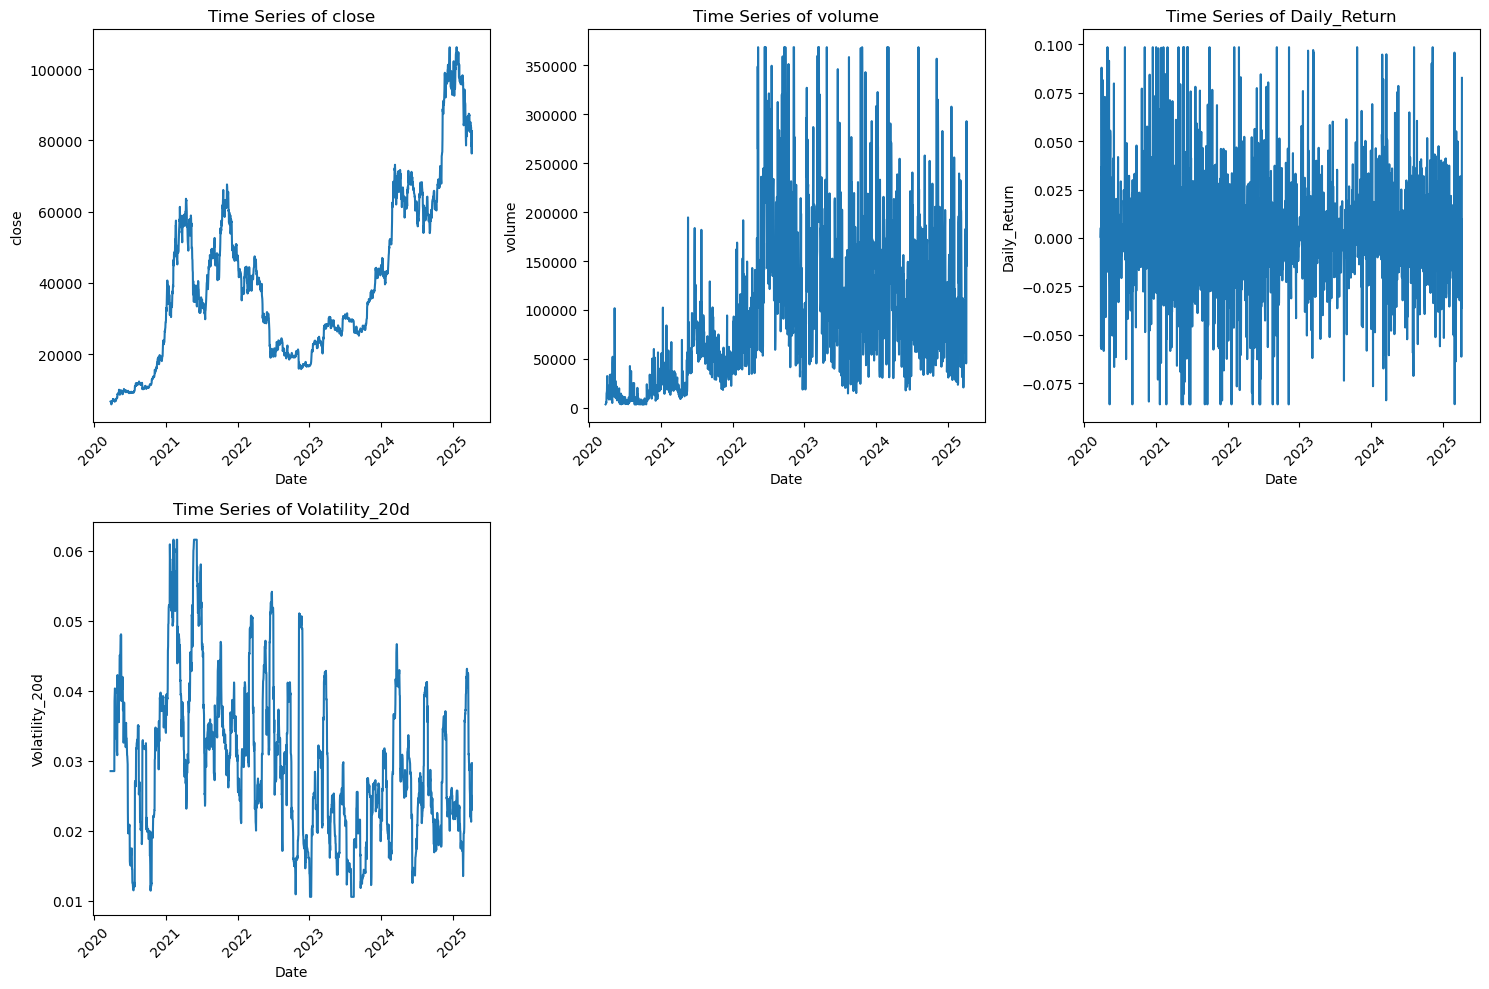

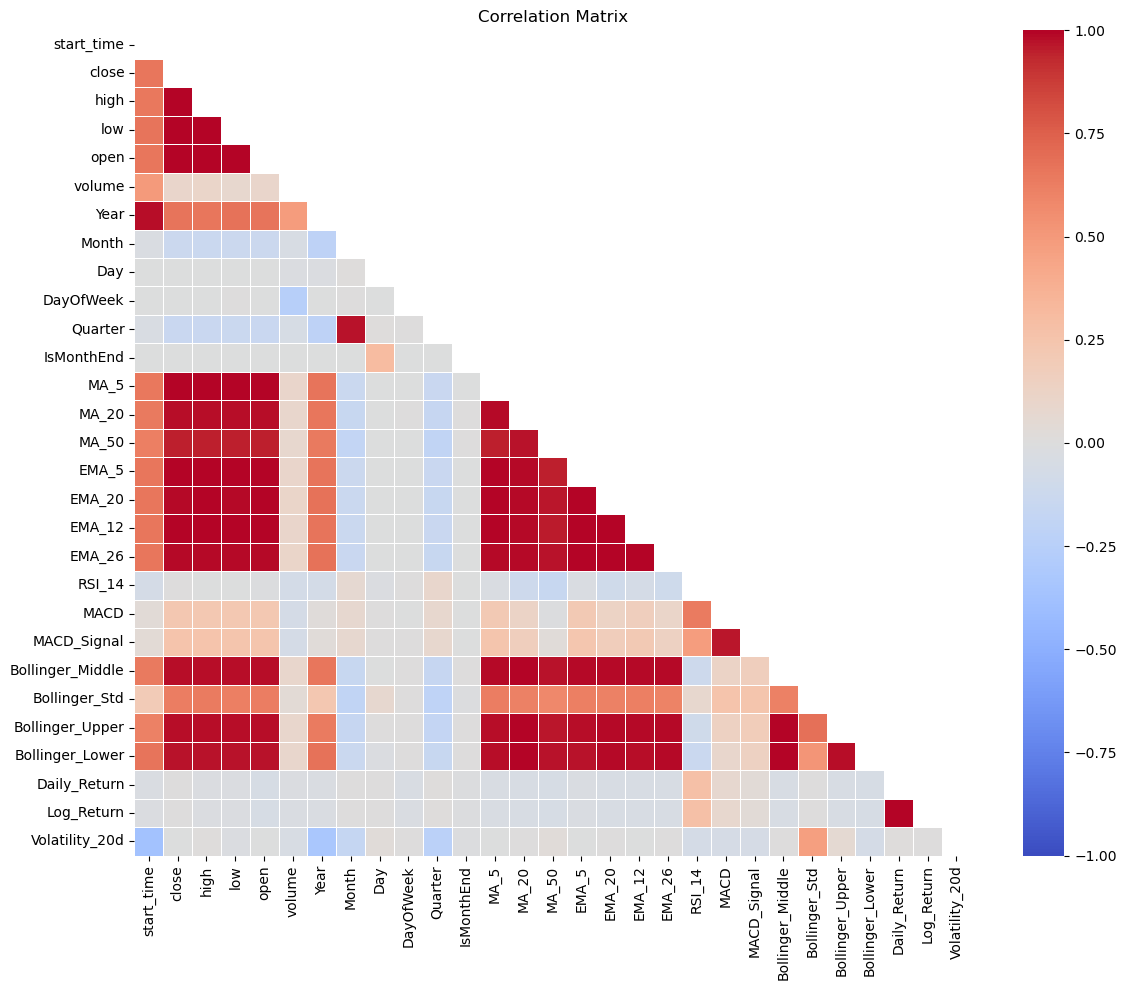

c:\Users\Alysha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


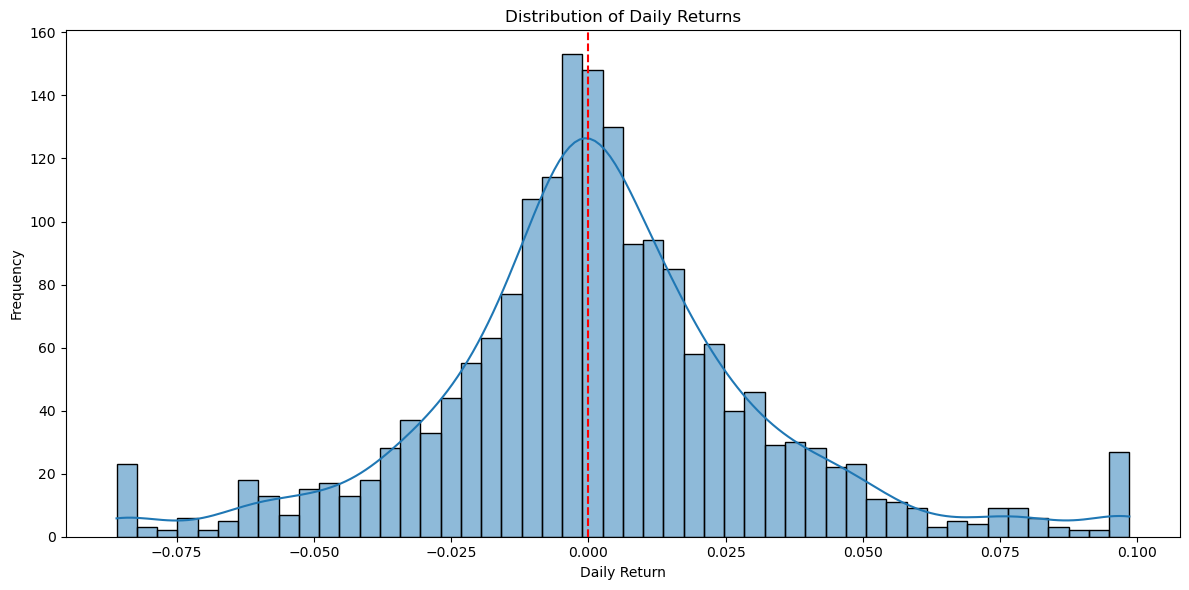

Processed data saved to C:\Users\Alysha\Downloads\alpha_strategy_pipeline\data\cleaned\cleaned_bybit_linear_BTCUSDT_1d.csv


In [7]:
df = process_market_data(r'C:\Users\Alysha\Downloads\alpha_strategy_pipeline\data\raw\bybit_linear_BTCUSDT_1d.csv', 
                         r'C:\Users\Alysha\Downloads\alpha_strategy_pipeline\data\cleaned\cleaned_bybit_linear_BTCUSDT_1d.csv',
                         visualize=True)  # Set to False if you don't want visualizations